In [119]:
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
import torch
from torch import nn
sys.path.insert(0, 'bin')

In [118]:
#local imports from the folder bin/
%load_ext autoreload
%autoreload 2

from split_data import split_train
from genre_encoder import GenreEncoder
from tokenizator import Tokenizer
from vocab import make_vocab
from prepare_data import DataPreprocessor, preprocess
from seq_dataset import SeqDataset, make_dataloader
from trainer import Trainer, freeze
from load_data import load_npz
from visualize import compare_on_plot
from models.rnn import RNNModel
from models.transformer import TransformerClassifier, AddCLS, PositionalEncoding

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Подготовка данных

## Разделение на train и val

Сначала разделим train на train и val в пропорции 3:1 и сохраним в `data/train75.pq`, `data/val25.pq` (осуществляется скриптом `split_data.py`)

In [3]:
split_train(path='train.csv', val_percent=25)

In [4]:
df_train = pd.read_parquet('data/train75.pq')
df_train

,name,genre,text
34357,"""Un prete tra noi"" (1997)",drama,Marco is a cultivated and intelligent priest....
23523,Canadian Dream (2011),drama,"When Amar immigrated to Canada, he brought wi..."
250,My tattoo (2016),drama,"In 2016, Shiho is going to marry her fiance b..."
23237,Ju san liang yi yi (1980),romance,Old 1970/80 Taiwanese romance movie. Errant L...
17707,"""My Auntie's Tall Tales"" (2017)",family,Six-year-old Theodor has been allowed to acco...
...,...,...,...
23712,Miami Our City (2016/II),documentary,Miami Our City is a film that examines the in...
10028,Niloye Jokhon (2012),drama,Home is where you feel ..... at home! It is a...
31017,"""After MASH"" (1983)",comedy,"Mildred takes a bus to Poplar Bluff, Missouri..."
31161,Shôto hôpu (2014),drama,An elementary school student Kazuya lives wit...


## Таргет-классы

Задача — определить жанр фильма по названию и описанию, т.е. классификация с несколькими классами

In [5]:
df_train.genre.value_counts()

drama          10210
documentary     9822
comedy          5585
short           3805
horror          1653
thriller        1193
action           986
western          774
reality-tv       663
family           588
adventure        581
music            548
romance          504
sci-fi           485
adult            442
crime            379
animation        374
sport            324
talk-show        293
fantasy          242
mystery          239
musical          208
biography        199
history          182
game-show        146
news             136
war               99
Name: genre, dtype: int64

Классы несбалансированы

In [6]:
df_train.genre.unique()

array(['drama', 'romance', 'family', 'documentary', 'comedy', 'action',
       'western', 'short', 'horror', 'music', 'talk-show', 'thriller',
       'sci-fi', 'reality-tv', 'game-show', 'adventure', 'mystery',
       'biography', 'adult', 'animation', 'musical', 'fantasy', 'sport',
       'war', 'history', 'crime', 'news'], dtype=object)

Для кодирования жанров будем использовать специальный энкодер жанров `GenreEncoder` из `genre_encoder.py`.

Подгрузим энкодер жанров и, если он ещё не «обучен» (т.е. если нет файла `data/train75_genres.txt` со списком жанров), то обучим его на `df_train`

In [8]:
genre_enc = GenreEncoder(txt_path='train75_genres.txt')
# Относительные пути — пути к файлам в 'data/'
if not genre_enc.ready():
    genre_enc.fit(df_train['genre'])

In [9]:
assert genre_enc.ready()
print(genre_enc.genres)

['drama', 'romance', 'family', 'documentary', 'comedy', 'action', 'western', 'short', 'horror', 'music', 'talk-show', 'thriller', 'sci-fi', 'reality-tv', 'game-show', 'adventure', 'mystery', 'biography', 'adult', 'animation', 'musical', 'fantasy', 'sport', 'war', 'history', 'crime', 'news', '<other>']


`genre_enc` имеет методы для кодирования жанра в числа, и обратно

In [10]:
df_train.genre[:10].apply(genre_enc.encode)

34357    0
23523    0
250      0
23237    1
17707    2
45332    3
24284    4
9989     4
43820    4
24727    5
Name: genre, dtype: int64

In [11]:
genre_enc.decode(0)

'drama'

In [12]:
# Неизвестные жанры преобразуются в '<other>':
genre_enc.encode('maho-shojo')

27

In [13]:
genre_enc.decode(27)

'<other>'

## Токенизатор

Для векторизации токенов будем использовать предобученные векторы из `data/glove.6B.300d.txt.zip`

Для адекватного испольование glove нужен токенизатор, который:
 - Заменяет сокращения на полные формы (I'm → I am)
 - Приводит текст к нижнему регистру
 - Сохраняет пунктуацию
 - Не удаляет стоп-слова
 - Не лемматизирует
 - Запоминает токены для создания словаря
 
Такой токенизатор реализован в `tokenizer.py`

In [14]:
tokenizer = Tokenizer() # пустой токенизатор
tokenizer.unique_tokens

set()

In [15]:
text1 = "Two Toes: The Coyote Legend of Green River"
print(tokenizer._tokenize_with_fit(text1)) # токенизирует и запоминает

['two', 'toes', ':', 'the', 'coyote', 'legend', 'of', 'green', 'river']


In [16]:
text2 = "The film's title refers not only to the un-recovered bodies at ground zero, "
"but also to the state of the nation at large."
print(tokenizer._just_tokenize(text1)) # просто токенизирует

['two', 'toes', ':', 'the', 'coyote', 'legend', 'of', 'green', 'river']


Токинизатор запомнил токены из `text1`, но не из `text2`

In [17]:
print(tokenizer.unique_tokens) 

{'green', 'two', 'of', 'the', 'river', 'coyote', ':', 'legend', 'toes'}


## Словарь и векторизация

Используем векторы из `data/glove.6B.300d.txt.zip`. Они имееют размерность 300.

Возмём только те слова, которые есть и в glove и запомнились токенизатором

In [18]:
vocab, vectors = make_vocab(tokens=tokenizer.unique_tokens)
print(vocab.decoder)

['<pad>', '<unk>', 'green', 'two', 'of', 'the', 'river', 'coyote', ':', 'legend', 'toes']


In [19]:
vectors.shape

(11, 300)

In [20]:
encoded_text = list(map(vocab.encode, text1.lower().split()))
print(encoded_text)

[3, 1, 5, 7, 9, 4, 2, 6]


In [21]:
decoded_text = list(map(vocab.decode, encoded_text))
print(decoded_text)

['two', '<unk>', 'the', 'coyote', 'legend', 'of', 'green', 'river']


Некоторые токены не попадают в словарь. Для английского текста их обычно не много. Однако есть описания на других языках. Их лучше отфильтровать на этапе обучения (для train и val). Для этого задаётся порог процентного содержания неизвестных токенов.

Словарь и вектора, обученные на всём df_train, сохранены в файлы `train75_vocab.txt`, `train75_vectors.npy`

In [22]:
del vocab, vectors

## Шаги предобработки данных

Для предобработки используется класс `DataPreprocessor` из `prepare_data.py`.

Экземпляр этого класса, выполняющий подготовку данных, содержит кодировщик жанров, токенизатор, словарь и массив векторов. При обучении их состояние записывается в соответствующие файлы, а потом восстонавливается методом `load_state`

В конструктор передаётся имя файла для жанров и порог содержания неизвестных слов для фильтрации.

In [23]:
preprocessor = DataPreprocessor(txt_path='train75_genres.txt', unk_threshold=0.1)
preprocessor.fitted

False

In [24]:
preprocessor.load_state('train75')
preprocessor.fitted

True

In [25]:
vectors = preprocessor.vectors
vectors.shape

(85667, 300)

Нулевой шаг — соединение названия с текстом по формуле

    X = name + '.' + text
выход: `X` и `y = genre`

In [27]:
X, y = preprocessor._preprocess0(df_train.iloc[:10])
X

34357     "Un prete tra noi" (1997) . Marco is a cultiv...
23523     Canadian Dream (2011) . When Amar immigrated ...
250       My tattoo (2016) . In 2016, Shiho is going to...
23237     Ju san liang yi yi (1980) . Old 1970/80 Taiwa...
17707     "My Auntie's Tall Tales" (2017) . Six-year-ol...
45332     Crossing White Lines (1999) . On April 15, 19...
24284     Cottonpickin' Chickenpickers (1967) . Darby C...
9989      Lan gun fu dou lan gun qi (2013) . Chinese Fe...
43820     "Immersion" (2010) . Ever wondered how video ...
24727     Los reptiles (1991) . There is a motorcycle g...
dtype: object

In [28]:
y

34357          drama
23523          drama
250            drama
23237        romance
17707         family
45332    documentary
24284         comedy
9989          comedy
43820         comedy
24727         action
Name: genre, dtype: object

Затем — кодирование жанров

In [29]:
y = preprocessor._preprocess1(y)
y

array([0, 0, 0, 1, 2, 3, 4, 4, 4, 5])

Следующий шаг — токенизация. Если словарь и вектора ещё не сохранены, то на этом этапе они создаются из train75

In [30]:
X = preprocessor._preprocess2(X, do_fit=False)
X

34357    [``, un, prete, tra, noi, '', (, 1997, ), ., m...
23523    [canadian, dream, (, 2011, ), ., when, amar, i...
250      [my, tattoo, (, 2016, ), ., in, 2016, ,, shiho...
23237    [ju, san, liang, yi, yi, (, 1980, ), ., old, 1...
17707    [``, my, auntie, 's, tall, tales, '', (, 2017,...
45332    [crossing, white, lines, (, 1999, ), ., on, ap...
24284    [cottonpickin, ', chickenpickers, (, 1967, ), ...
9989     [lan, gun, fu, dou, lan, gun, qi, (, 2013, ), ...
43820    [``, immersion, '', (, 2010, ), ., ever, wonde...
24727    [los, reptiles, (, 1991, ), ., there, is, a, m...
dtype: object

С помощью словаря токены кодируются для компактного хранения в файле.

In [31]:
X = preprocessor._preprocess3(X)
X

34357    [40424, 11063, 50860, 15163, 72573, 62151, 101...
23523    [73177, 32392, 10180, 37460, 5627, 47462, 4427...
250      [25658, 24013, 10180, 18027, 5627, 47462, 7520...
23237    [42189, 70281, 64454, 81932, 81932, 10180, 595...
17707    [40424, 25658, 68304, 78533, 40507, 37184, 621...
45332    [44920, 74158, 38930, 10180, 8592, 5627, 47462...
24284    [1, 55991, 1, 10180, 21717, 5627, 47462, 7505,...
9989     [34055, 24497, 77477, 42154, 34055, 24497, 424...
43820    [40424, 51805, 62151, 10180, 82188, 5627, 4746...
24727    [8152, 17256, 10180, 77452, 5627, 47462, 52633...
dtype: object

Поскольку последовательности кодов имеют разную длину,
то для хранения данных X переводится в одномерный массив,
а для его обратного превращения в набор последовательностей
сохраняются длины этих последовательностей.

Здесь же происходит фильтрация по количеству неизвестных слов

In [32]:
X, lengths, y = preprocessor._preprocess4(X, y, filter_unknown=True)
X.shape, lengths.shape, y.shape

English filter: 0.0 filtered


((1231,), (10,), (10,))

Файл `prepare_data.py` — это скрипт, призапуске которого происходит предобработка данных `data/train75.pq` и `data/val25.pq` и запись полученных массивов X, y, z в файлы `data/train75.npz`, `data/val25.npz` соответственно.

## Dataset и dataloader

Торчёвый датасет создаётся из массивов `X, lengths, y`. Они компактно храняться внутри вместе с индексами начала каждой последовательности. При вызове __getitem__ выдёргивается нужный кусок из X.

In [33]:
small_dataset = SeqDataset(X, lengths, y, vectors, compute_y_weights=True)
len(small_dataset)

10

In [34]:
small_dataset.X

tensor([40424, 11063, 50860,  ..., 44269, 38805, 11969])

In [35]:
small_dataset.pointers

tensor([   0,  201,  291,  365,  495,  661,  752,  937, 1054, 1165, 1231])

In [36]:
small_dataset.y

tensor([0, 0, 0, 1, 2, 3, 4, 4, 4, 5])

In [37]:
small_dataset.X[201:205]

tensor([73177, 32392, 10180, 37460])

In [38]:
X0, y0 = small_dataset[1]
X0, y0

(tensor([[ 0.1267,  0.3602, -0.3693,  ...,  0.5320,  0.0703, -0.3471],
         [ 0.0030,  0.4506, -0.0134,  ..., -0.1304, -0.4271,  0.6269],
         [-0.1686, -0.1958, -0.2025,  ..., -0.4990,  0.2265, -0.2899],
         ...,
         [ 0.1267,  0.3602, -0.3693,  ...,  0.5320,  0.0703, -0.3471],
         [ 0.0030,  0.4506, -0.0134,  ..., -0.1304, -0.4271,  0.6269],
         [-0.1256,  0.0136,  0.1031,  ..., -0.3422, -0.0224,  0.1368]]),
 tensor(0))

Опциия `compute_y_weights` добавляет поле `class_weights` в котором посчитамы веса классов
для данного датасета. Предполагается использовать её для train.

In [39]:
small_dataset.class_weights

tensor([0.5556, 1.6667, 1.6667, 1.6667, 0.5556, 1.6667])

$i$-й элемент этого тензора — вес жанра с кодом $i$

In [40]:
preprocessor.genre_encoder.decode(y0.item())

'drama'

`Dataloader` преобразует X, y в `PackedSequence` и `torch.LongTensor` соответственно. При его создании указывается имя файла, из которого он берёт массивы `X, length, y`

In [41]:
dataloader = make_dataloader(path='train75')
len(dataloader.dataset)

40239

Также подсчитывается максимальная длина последовательностей. Она понадобится для позиционного кодирования.

In [42]:
dataloader.dataset.max_length

2113

In [43]:
X_seq, y_t = next(iter(dataloader))
len(X_seq), y_t.shape

(4, torch.Size([32]))

In [44]:
X_seq

PackedSequence(data=tensor([[-0.2852, -0.0139,  0.3161,  ..., -0.1086, -0.1435,  0.1485],
        [-0.2228, -0.3046,  0.1773,  ..., -0.1176, -0.1375,  0.3299],
        [-0.7242,  0.2033, -0.2540,  ..., -0.0354,  0.0589, -0.4750],
        ...,
        [ 0.3251,  0.0184, -0.0720,  ..., -0.1204, -0.2595, -0.4693],
        [-0.0562,  0.3544,  0.9249,  ...,  0.4352,  0.1860, -0.1543],
        [-0.1256,  0.0136,  0.1031,  ..., -0.3422, -0.0224,  0.1368]]), batch_sizes=tensor([32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 31, 31, 31, 31, 31, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 27, 27, 26, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 23,
        23, 23, 23, 23, 21, 19, 19, 18, 18, 17, 17, 17, 17, 17, 16, 16, 16, 15,
        15, 14, 12, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10,  9,  9,  9,  9,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  

In [45]:
y_t # Жанры из батча

tensor([ 3,  3,  7,  3,  4,  0,  4,  0,  8,  0,  5,  0,  0,  4,  4, 25,  3,  7,
         0,  0, 11,  3,  5, 19,  3,  4,  5,  0,  7,  7,  4,  0])

In [46]:
dataloader.dataset.class_weights # Веса для всех жанров

tensor([ 0.1480,  2.9987,  2.5607,  0.1525,  0.2726,  1.5192,  1.9255,  0.3944,
         0.9043,  2.7701,  5.1748,  1.2545,  3.0792,  2.2547, 10.2078,  2.6055,
         6.2357,  7.6037,  3.3718,  4.0498,  7.3056,  6.2357,  4.6573, 15.0539,
         8.2796,  3.9848, 10.9583])

In [47]:
del small_dataset, X0, y0, y_t

# Слои для обработки последовательностей

Для классификации последовательностей, в часности токенизированный текстов, можно использовать следующие типы моделей:
 - классические RNN-модели
 - RNN-модели с механизмом внимания
 - Трансформеры, предложенные в "Attention Is All You Need"

В этом разделе изучим как работают некоторые интересные слои этих моделей

## RNN: GRU-слой

Для построения RNN-моделей будем использовать слои GRU из-за ограниченности в ресурсах

In [48]:
gru = nn.GRU(
    input_size=dataloader.dataset.embedding_dim,
    hidden_size=64, num_layers=2, bias=True, batch_first=True, bidirectional=False)
gru

GRU(300, 64, num_layers=2, batch_first=True)

Как раз для таких слоёв ранее был сделан `SeqDataset`, который выдаёт последовательность запакованную в `PackedSequence`

In [49]:
gru_out = gru(X_seq)
type(X_seq), type(gru_out)

(torch.nn.utils.rnn.PackedSequence, tuple)

Выход слоя (модуля из двух подслоёв) — последовательность для последующей обработки и финальный "hidden state" каждого подслоя. Последний имеет форму `[num_layes, batch_size, hidden_size]`.

In [50]:
seq, h = gru_out
type(seq), type(h), h.shape

(torch.nn.utils.rnn.PackedSequence, torch.Tensor, torch.Size([2, 32, 64]))

RNN-слой обрабатывает каждую последовательность из `PackedSequence` вдоль его собственной длинны, фактически иггнорируя паддинг. В этом можно убедится, распаковав последовательность.

In [51]:
x, lengths = nn.utils.rnn.pad_packed_sequence(seq, batch_first=True)
assert type(x) == type(lengths) == torch.Tensor
x.shape, lengths.shape, lengths

(torch.Size([32, 354, 64]),
 torch.Size([32]),
 tensor([354, 289, 202, 192, 190, 173, 151, 123, 107, 103,  99,  93,  92,  92,
          91,  89,  86,  81,  79,  77,  77,  76,  76,  71,  71,  61,  60,  58,
          58,  58,  46,  41]))

Здесь общая длинна последовательностей с паддингом равна `lengths.shape[1]` == `lengths[0]`.

Начиная со второй последовательности в конце они дополнены нулевыми векторами (паддинг)

In [52]:
x[-1, -1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SelectBackward0>)

Последний элемент `i`-ой последовательности находится в месте под индексом `lengths[i] - 1`. Их можно выделить следующим образом.

In [53]:
x[range(x.shape[0]), lengths-1].shape

torch.Size([32, 64])

Проверим, что они действительно совпадают с финальным состоянием последнего подслоя.

In [54]:
(h[-1] == x[range(x.shape[0]), lengths-1]).all()

tensor(True)

Таким образом можно подавать вектор `h[-1]` на первый линейный слой подмодуля классификации.

В случае двунаправленной RNN-модели мы конкатинируем финальные состояния прямого и обратного проходов — векторы `h[-2]` и `h[-1]`

In [55]:
gru = nn.GRU(
    input_size=dataloader.dataset.embedding_dim,
    hidden_size=64, num_layers=2, bias=True, batch_first=True, bidirectional=True)
seq, h_bd = gru(X_seq)
h_bd.shape

torch.Size([4, 32, 64])

Здесь тензор `h_bd` имеет форму `[2*num_layers, batch_size, hidden_size]` — в каждом батче по 2 вектора на каждый слой.

In [56]:
final_hidden_state = torch.cat((h_bd[-2], h_bd[-1]), dim=1)
final_hidden_state.shape # [batch_size, 2*hidden_size]

torch.Size([32, 128])

В этом случае входным тензором первого линейного слоя является сконкатенированный тензор `final_hidden_state`

Полностью модель реализована в `rnn.py` (случай `n_heads` = 0)

In [57]:
del gru, seq, h_bd, final_hidden_state

## Attention

Рекуррентные нейронные сети могут в процессе обработки длинных последовательностей забывать, что было в начале и даже в середине. Добавление обратного прохода проблему не решает. Кроме того, сети сложно запихнуть всю информацию о последовательности в два финальных вектора.

Для решения этой проблемы применяется механизм внимания. При обработке рекуррентными сетями он обычно добавляется после последнего RNN-слоя в виде "Self-Attention". Для этого в `torch` есть слой `nn.MultiheadAttention`.

In [58]:
multihead = nn.MultiheadAttention(embed_dim=h.shape[2], num_heads=4, batch_first=True)
multihead

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
)

Чтобы применить этот слой к батчу из последовательности правильно надо передать маску, которая имеет форму `[batch_size, x.shape[1]]` и указывает в каких местах не надо игнорировать элемены входного массива `x` (точнее `key` и `value`).

In [59]:
def make_mask(shape, lengths): # models.common.py
    batch_size, max_len, _ = shape
    return torch.arange(max_len).expand(batch_size, max_len) >= lengths.unsqueeze(1)
make_mask((3,4, 32), lengths=torch.LongTensor([4,3,2]))

tensor([[False, False, False, False],
        [False, False, False,  True],
        [False, False,  True,  True]])

In [60]:
mask = make_mask(x.shape, lengths)
mask.shape

torch.Size([32, 354])

Можно просто применить `Self-Attention` ко всей последовательности передав в `multihead` тензор `x` в качестве `query`, `key` и `value`, после чего выыделить нужный элемент в каждой последовательности.

In [61]:
output, _ = multihead(query=x, key=x, value=x, key_padding_mask=mask)
final_out = output[range(output.shape[0]), lengths-1]
output.shape, final_out.shape

(torch.Size([32, 354, 64]), torch.Size([32, 64]))

Однако это не эффективно. К счастью `MultiheadAttention` может принимать на вход последовательности query и key разной длины (лишь длины value и key должны совпадать). Поэтому лучше применять внимание, взяв в качестве query последовательность единичной длины. Последняя получается из `h[-1]` добавлением оси 1.

In [62]:
hu = h[-1].unsqueeze(1)
assert (hu.squeeze(1) == h[-1]).all()
hu.shape

torch.Size([32, 1, 64])

Такой подход имеет линейную сложность относительно длины последовательности, вместо квадратичной сложности. 

In [63]:
effectively_made_output, _ = multihead(query=hu, key=x, value=x, key_padding_mask=mask)
effectively_made_output.shape

torch.Size([32, 1, 64])

In [64]:
effectively_made_output.squeeze_(1)
effectively_made_output.shape

torch.Size([32, 64])

Тензор `effectively_made_output` подаётся в линейные слои для классификации.

Полностью модель реализована в `rnn.py` (случай `n_heads` > 0)

In [65]:
del multihead, hu, mask, effectively_made_output, h, x

## Трансформер

Трансформер реализован в `transformer.py` и состоит из следующих частей:
 - `AddCLS`: Добавление специального токена `[CLS]` (classification) в начало последовательности
 - `PositionalEncoding`: Синусоидальное позиционное кодирование
 - `TransformerEncoder`: Основной слой трансформера, состоящий из нескольких TransformerEncoderLayer
 - `MultiheadAttention` вместо последнего TransformerEncoderLayer
 - Плюс всё те же линейные слои для классификации

`AddCLS` добавляет вектор размерности 300, элементами которого являются обучаемые веса, с помощью конкатенации 

In [66]:
cls_adder = AddCLS(emb_dim=dataloader.dataset.embedding_dim)
x, xengths = nn.utils.rnn.pad_packed_sequence(X_seq, batch_first=True)
X, Lengths = cls_adder(x, lengths)
assert (X[:, 1:] == x).all()
assert (Lengths == lengths + 1).all()
x.shape, X.shape, lengths, Lengths

(torch.Size([32, 354, 300]),
 torch.Size([32, 355, 300]),
 tensor([354, 289, 202, 192, 190, 173, 151, 123, 107, 103,  99,  93,  92,  92,
          91,  89,  86,  81,  79,  77,  77,  76,  76,  71,  71,  61,  60,  58,
          58,  58,  46,  41]),
 tensor([355, 290, 203, 193, 191, 174, 152, 124, 108, 104, 100,  94,  93,  93,
          92,  90,  87,  82,  80,  78,  78,  77,  77,  72,  72,  62,  61,  59,
          59,  59,  47,  42]))

Далее к вектору `X_ext` прибавляется необучаемый вектор кодирующий позицию с помощью сунусов и косинусов

In [67]:
pos_enc = PositionalEncoding(
        embedding_dim=dataloader.dataset.embedding_dim,
        max_len=dataloader.dataset.max_length,
    )
X = pos_enc(X) # прибавление происходит в методе forward
X.shape

torch.Size([32, 355, 300])

Основной слой — это трансформер, преоюразующий последовательность в последовательность. Он содержит Multihead Self-Attention, Feed Forward, нормализацию, dropout и resudual connections (для Sefl-Atention и для Feed Forward). Как в отдельный Multihead Attention, сюда передаётся маска паддинга.

In [68]:
encoder_layer = nn.TransformerEncoderLayer(
        d_model=dataloader.dataset.embedding_dim,
        nhead=4,
        dim_feedforward=1500,
        batch_first=True,
    )
tr_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
Mask = make_mask(X.shape, Lengths)
out = tr_encoder(X, src_key_padding_mask=Mask)
out.shape

torch.Size([32, 355, 300])

В качестве входа первого линейного слоя можно взять просто `tr_out[:, 0, :]`, но, как и в случае с RNN, это неэффективно. Поэтому добавляем ещё один MultiheadAttention с query единичной длины + resudual connections. Вместе с последующими линейными слоями это фактически заменяет ещё один слой TransformerEncoderLayer. Можно было ещё линейных слоёв добавить, но должно и так работать.

In [69]:
multihead = nn.MultiheadAttention(
        embed_dim=dataloader.dataset.embedding_dim,
        num_heads=4,
        batch_first=True
    )

query = out[:, 0:1, :]
multihead_out, _ = multihead(query, out, out, key_padding_mask=Mask)
input_of_linear_layer= (multihead_out + query).squeeze(1)
input_of_linear_layer.shape

torch.Size([32, 300])

In [70]:
del encoder_layer, tr_encoder, multihead, cls_adder, pos_enc
del out, query, multihead_out, input_of_linear_layer, x, lengths, Lengths, X, Mask

# Обучение и оценка

## Загрузчики для оценки

Предобоработаем тестовые данные для создания датасета с загрузчиком

In [71]:
#preprocess(path='test.csv', do_fit=False, filename='train75', unk_threshold=-1)
#preprocess(path='val25.pq', do_fit=False, filename='train75',
#           unk_threshold=-1, npz_path='val4test25.npz')

In [72]:
valloader = make_dataloader(
        path='val4test25', # вариант без фильтрации
        vector_path='train75_vectors.npy',
        batch_size=32,
        for_train=False
    )
len(valloader.dataset)

13554

In [73]:
testloader = make_dataloader(
        path='test', # эти данные тоже не фильтровались
        vector_path='train75_vectors.npy',
        batch_size=1,
        for_train=False,
        shuffle=False,
    )
len(testloader.dataset)

54200

Так же понадобятся следующие функции

In [74]:
def load_val(path='data/val25.pq', from_row=0, to_row=None):
    """ Загрузка данных из parquet-файла с номерами строк из заданного диипазона """
    df_val = pd.read_parquet(path).reset_index().drop('index', axis=1)
    if to_row is None:
        to_row = len(df_val)
    return df_val.iloc[from_row:to_row]

In [75]:
def prediction_table(dataloader, model, from_row=0, to_row=None):
    """ Загрузка данных через dataloader с номерами строк из заданного диипазона
        для получения на них предсказаний
    """
    model.eval()
    freeze(model)
    labels = []
    preds = []
    for seq, y in dataloader:
        labels.extend(y.numpy().tolist())
        p = model(seq)
        p = np.argmax(p.numpy(), axis=1)
        preds.extend(p.tolist())
        if to_row is not None and len(preds) >= to_row:
            break
    if to_row is None:
        to_row = len(preds)
    return pd.DataFrame(dict(preds=preds[from_row:to_row], labels=labels[from_row:to_row]))

## Параметры

Используемый оптимизатор:

AdamW (

 - amsgrad: False
 - betas: (0.9, 0.999)
 - capturable: False
 - decoupled_weight_decay: True
 - differentiable: False
 - eps: 1e-08
 - foreach: None
 - fused: None
 - lr: 0.0001
 - maximize: False
 - weight_decay: 0.01
  
)

Другие параметры обучения (тоже фиксированы):
 - EPOCHS=25
 - BATCH_SIZE=32
 
Параметры модели (пробуются разные):
 - NET_CLASS — тип RNN-слоя, либо равен 'transformer'
 - HIDDEN_DIM — задаёт `hidden_dim` для RNN, или `dim_feedforward` для 'transformer' 
 - DROPOUT — для RNN, feedforward и attention
 - DROPOUT_LIN — для линейных слоёв
 - N_LAYERS — количество RNN-подслоёв или `TransformerEncoderLayer` (если N_HEAD > 0, то есть ещё один слой внимания без FNN)
 - N_HEADS — количество «голов» внимания (значение 0 используется для RNN без внимания)
 - BIDIRECTIONAL (используется только в случае RNN без внимания)

Для обучения использовался класс `Trainer`. Его можно так же использовать и для оценки.

In [76]:
trainer = Trainer(device='cpu', checkpoints_dir=None, logger=None)

In [77]:
# Используемые метрики

def f1_macro(gt, pred):
    assert len(gt) == len(pred)
    return f1_score(gt, pred, average="macro")

def accuracy(gt, pred):
    assert len(gt) == len(pred)
    return (gt == pred).mean()

## RNN

Модель RNN с GRU-слоями без внимания:
 - NET_CLASS = 'GRU'
 - HIDDEN_DIM = 128
 - DROPOUT = 0.1
 - DROPOUT_LIN = 0.2
 - N_LAYERS = 2
 - BIDIRECTIONAL = True

Получены метрики:
 - Train:          f1_macro = 0.409

 - Validation:     f1_macro = 0.304

Best checkpoints with this metric was saved to 'GRU_l2_h128_D2_ep25_best.pt' at epoch 22

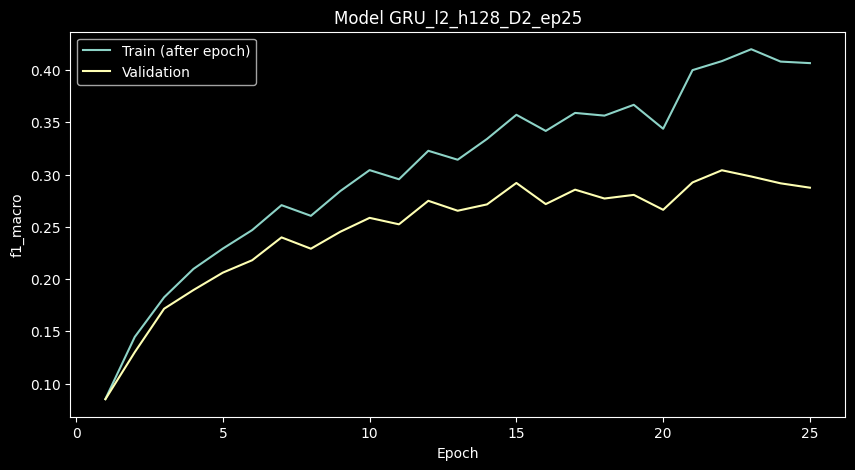

In [78]:
history = load_npz('history/2025-09-28_01:28:59.npz')
rnn_name = 'GRU_l2_h128_D2_ep25'
compare_on_plot(history, name=rnn_name, metric_name='f1_macro')

In [79]:
rnn_model = RNNModel(
         300, # разнерность векторов в glove
         output_dim=27, # количество жанров
         hidden_dim=128,
         rnn_class='GRU',
         bidirectional=True,
         dropout=0, # для оценки не нужны
         dropout_lin=0,
         n_layers=2,
         two_dense=True,
         n_heads = 0, # без внимания
    ).eval()
freeze(rnn_model)
checkpoint = f"checkpoints/{rnn_name}_best.pt"
rnn_model.load_state_dict(torch.load(checkpoint, map_location='cpu'))

<All keys matched successfully>

In [80]:
out_dict = {}
metrics_on_test = trainer.evaluation(
    rnn_model,
    valloader,
    out_dict=out_dict,
    metrics=[f1_macro, accuracy],
)

100%|██████████| 424/424 [00:51<00:00,  8.30it/s]


In [81]:
print("On validation data: F1 (macro) = %.3f" % metrics_on_test[0])
print("On validation data: accuracy = %.3f" % metrics_on_test[1])

On validation data: F1 (macro) = 0.302
On validation data: accuracy = 0.357


Посмотрим на первые несколько предсказаний

In [120]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
genre_enc = GenreEncoder(txt_path='train75_genres.txt')

In [83]:
from_row=0
to_row_val=10

In [84]:
val_preds = prediction_table(valloader, rnn_model, from_row=from_row, to_row=to_row_val)['preds']
df_val = load_val('data/val25.pq', from_row, to_row_val)
df_val['preds_rnn'] = val_preds.apply(genre_enc.decode)
df_val

,name,genre,text,preds_rnn
0,Tony & the Swordfish Tattoo (2017),short,"Tony Campi, a recreational fisherman, tried f...",documentary
1,Two Toes: The Coyote Legend of Green River (?...,drama,"At the height of the Great Depression, after ...",reality-tv
2,Le silence de la peur (2002),drama,Children are the victims of rackets and viole...,mystery
3,Intertwined (2015),short,Chasing dreams. Leo Armstrong born a dancer h...,western
4,Q.L.U.E: The Forgotten Man Part Two (2014),action,"Shortly after Ace Queens' assassination, Davi...",biography
5,Santoro O Homem e Sua Música (2015),documentary,"Santoro- The Man and His Music (75 ', color a...",horror
6,Satte Farben vor Schwarz (2010),drama,The love story of an elderly couple. Having a...,crime
7,"""Kicsi ország, kicsi Kína"" (2015)",documentary,"In 1989, Hungary opened its doors to the Chin...",family
8,Reisen ins Leben (1996),documentary,Journey into Life follows the struggles of th...,documentary
9,The Bookfair Murders (2000),mystery,Halifax Chronicle-Herald newspaper reporter J...,adult


В `test.csv` нет меток (засада!)

Пришлось погуглить.

In [85]:
from_row=0
to_row=21
first_test_genres = [
       'thriller', 'comedy', 'documentary', 'drama', 'drama', # 0–4
       'horror', 'drama', 'comedy', 'documentary', 'drama', 
        'drama', 'drama', 'drama', 'drama', 'short', # 10–14
        'documentary', 'comedy', 'drama', 'documentary', 'documentary',
        'short', # 20
    ]
df_test = pd.read_csv('data/test.csv', nrows=to_row).iloc[from_row:]
df_test['labels'] = first_test_genres

In [86]:
test_preds = prediction_table(testloader, rnn_model, from_row=from_row, to_row=to_row)['preds']
df_test['preds_rnn'] = test_preds.apply(genre_enc.decode)
assert (df_test['labels'].apply(genre_enc.encode) != 27).all()
#df_test['preds1'] = prediction_table(testdataloader, rnn_model)['preds'].apply(genre_enc.decode)
df_test

,name,text,labels,preds_rnn
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",thriller,thriller
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",comedy,drama
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...,documentary,documentary
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",drama,family
4,Er nu zhai (1955),Before he was known internationally as a mart...,drama,romance
5,Riddle Room (2016),Emily Burns is being held captive in a room w...,horror,thriller
6,L'amica (1969),The beautiful but neglected wife of a brillia...,drama,drama
7,Ina Mina Dika (1989),Vasu Inamdar (Ina) suffers from a disorder wh...,comedy,drama
8,Equinox Special: Britain's Tornados (2005),An insight into the tornados that hit Kensal ...,documentary,documentary
9,Press (2011),Press is a story of young people overwhelmed ...,drama,short


In [87]:
TP = (df_test.preds_rnn == df_test.labels).sum()
f'Угадано {TP} из {len(df_test)}: accuracy = {TP/len(df_test):.3f}'

'Угадано 6 из 21: accuracy = 0.286'

## RNN + Attention

Модель RNN с GRU-слоями и Multihead-attention-слоем после:
 - NET_CLASS = 'GRU'
 - HIDDEN_DIM = 128
 - DROPOUT = 0.1
 - DROPOUT_LIN = 0.2
 - N_LAYERS = 2
 - N_HEAD_S = 4

Получены метрики:
 - Train:  f1_macro = 0.319
 - Validation:     f1_macro = 0.256

Best checkpoints with this metric was saved to 'GRU_l2_h128_att4_ep25_best.pt' at epoch 24

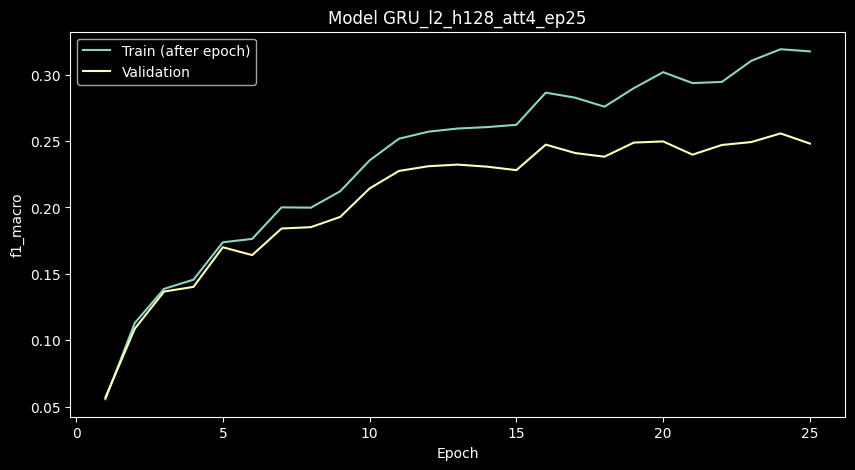

In [88]:
history = load_npz('history/2025-09-28_00:46:42.npz')
rnn_att_name='GRU_l2_h128_att4_ep25'
compare_on_plot(history, name=rnn_att_name, metric_name='f1_macro')

In [89]:
rnn_att_model = RNNModel(
         300,
         output_dim=27,
         hidden_dim=128,
         rnn_class='GRU',
         bidirectional=False,
         dropout=0,
         dropout_lin=0,
         n_layers=2,
         two_dense=True,
         n_heads = 4, # четыре головы внимания
    ).eval()
freeze(rnn_att_model)
checkpoint = f"checkpoints/{rnn_att_name}_best.pt"
rnn_att_model.load_state_dict(torch.load(checkpoint, map_location='cpu'))

<All keys matched successfully>

In [90]:
out_dict = {}
metrics_on_test = trainer.evaluation(
    rnn_att_model,
    valloader,
    out_dict=out_dict,
    metrics=[f1_macro, accuracy],
)

100%|██████████| 424/424 [00:30<00:00, 13.74it/s]


In [91]:
print("On validation data: F1 (macro) = %.3f" % metrics_on_test[0])
print("On validation data: accuracy = %.3f" % metrics_on_test[1])

On validation data: F1 (macro) = 0.254
On validation data: accuracy = 0.249


Метрики хуже, поскольку применяется проход по последовательности только в прямую сторону, без обратного

In [92]:
val_preds = prediction_table(valloader, rnn_att_model, from_row=from_row, to_row=to_row_val)['preds']
df_val['preds_rnn_att'] = val_preds.apply(genre_enc.decode)
df_val

,name,genre,text,preds_rnn,preds_rnn_att
0,Tony & the Swordfish Tattoo (2017),short,"Tony Campi, a recreational fisherman, tried f...",documentary,documentary
1,Two Toes: The Coyote Legend of Green River (?...,drama,"At the height of the Great Depression, after ...",reality-tv,game-show
2,Le silence de la peur (2002),drama,Children are the victims of rackets and viole...,mystery,mystery
3,Intertwined (2015),short,Chasing dreams. Leo Armstrong born a dancer h...,western,adventure
4,Q.L.U.E: The Forgotten Man Part Two (2014),action,"Shortly after Ace Queens' assassination, Davi...",biography,biography
5,Santoro O Homem e Sua Música (2015),documentary,"Santoro- The Man and His Music (75 ', color a...",horror,horror
6,Satte Farben vor Schwarz (2010),drama,The love story of an elderly couple. Having a...,crime,action
7,"""Kicsi ország, kicsi Kína"" (2015)",documentary,"In 1989, Hungary opened its doors to the Chin...",family,family
8,Reisen ins Leben (1996),documentary,Journey into Life follows the struggles of th...,documentary,biography
9,The Bookfair Murders (2000),mystery,Halifax Chronicle-Herald newspaper reporter J...,adult,comedy


In [93]:
test_preds = prediction_table(testloader, rnn_att_model, from_row=from_row, to_row=to_row)['preds']
df_test['preds_rnn_att'] = test_preds.apply(genre_enc.decode)
df_test

,name,text,labels,preds_rnn,preds_rnn_att
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",thriller,thriller,sci-fi
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",comedy,drama,drama
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...,documentary,documentary,documentary
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",drama,family,romance
4,Er nu zhai (1955),Before he was known internationally as a mart...,drama,romance,drama
5,Riddle Room (2016),Emily Burns is being held captive in a room w...,horror,thriller,thriller
6,L'amica (1969),The beautiful but neglected wife of a brillia...,drama,drama,romance
7,Ina Mina Dika (1989),Vasu Inamdar (Ina) suffers from a disorder wh...,comedy,drama,family
8,Equinox Special: Britain's Tornados (2005),An insight into the tornados that hit Kensal ...,documentary,documentary,news
9,Press (2011),Press is a story of young people overwhelmed ...,drama,short,biography


In [94]:
TP = (df_test.preds_rnn_att == df_test.labels).sum()
f'Угадано {TP} из {len(df_test)}: accuracy = {TP/len(df_test):.3f}'

'Угадано 2 из 21: accuracy = 0.095'

Не повезло

## Transformer

Трансформер:
 - NET_CLASS = 'transformer'
 - HIDDEN_DIM = 1200
 - DROPOUT = 0.1
 - DROPOUT_LIN = 0.2
 - N_LAYERS = 2
 - N_HEAD_S = 4

Получены метрики:
 - Train:  f1_macro = 0.712
 - Validation:     f1_macro = 0.353

Best checkpoints with this metric was saved to 'transformer_l2_h1200_att4_ep25_best.pt' at epoch 23

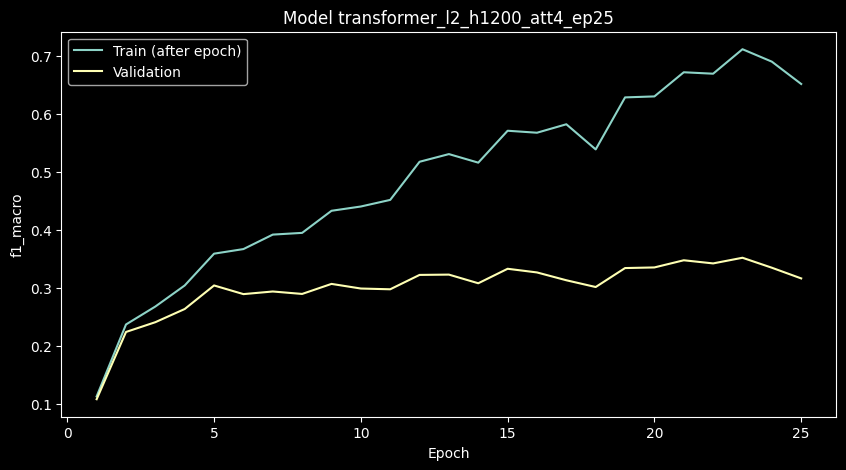

In [95]:
history = load_npz('history/2025-09-28_00:08:24.npz')
tr_name='transformer_l2_h1200_att4_ep25'
compare_on_plot(history, name=tr_name, metric_name='f1_macro')

Выглядит страшно, но на валидации метрика выше, чем при бóльшем dropout

In [96]:
tr_model = TransformerClassifier(
            num_classes=27,
            embedding_dim=300,
            n_heads=4,
            num_layers=2,
            dim_feedforward=1200,
            max_seq_len=dataloader.dataset.max_length,
            dropout=0,
            dropout_lin=0,
            add_cls=True, # с токеном [CLS] в начеле последовательности
            final_attention=True, # со слоем MultiheadAttention после трансформера
        )

freeze(tr_model)
checkpoint = f"checkpoints/{tr_name}_best.pt"
tr_model.load_state_dict(torch.load(checkpoint, map_location='cpu'))

<All keys matched successfully>

In [97]:
out_dict = {}
metrics_on_test = trainer.evaluation(
    tr_model,
    valloader,
    out_dict=out_dict,
    metrics=[f1_macro, accuracy],
)
print("On validation data: F1 (macro) = %.3f" % metrics_on_test[0])
print("On validation data: accuracy = %.3f" % metrics_on_test[1])

  0%|          | 0/424 [00:00<?, ?it/s]/home/silant/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
100%|██████████| 424/424 [03:24<00:00,  2.08it/s]

On validation data: F1 (macro) = 0.352
On validation data: accuracy = 0.478


In [101]:
val_preds = prediction_table(valloader, tr_model, from_row=from_row, to_row=to_row_val)['preds']
df_val['preds_tr'] = val_preds.apply(genre_enc.decode)
df_val

,name,genre,text,preds_rnn,preds_rnn_att,preds_tr
0,Tony & the Swordfish Tattoo (2017),short,"Tony Campi, a recreational fisherman, tried f...",documentary,documentary,documentary
1,Two Toes: The Coyote Legend of Green River (?...,drama,"At the height of the Great Depression, after ...",reality-tv,game-show,reality-tv
2,Le silence de la peur (2002),drama,Children are the victims of rackets and viole...,mystery,mystery,thriller
3,Intertwined (2015),short,Chasing dreams. Leo Armstrong born a dancer h...,western,adventure,drama
4,Q.L.U.E: The Forgotten Man Part Two (2014),action,"Shortly after Ace Queens' assassination, Davi...",biography,biography,documentary
5,Santoro O Homem e Sua Música (2015),documentary,"Santoro- The Man and His Music (75 ', color a...",horror,horror,thriller
6,Satte Farben vor Schwarz (2010),drama,The love story of an elderly couple. Having a...,crime,action,crime
7,"""Kicsi ország, kicsi Kína"" (2015)",documentary,"In 1989, Hungary opened its doors to the Chin...",family,family,documentary
8,Reisen ins Leben (1996),documentary,Journey into Life follows the struggles of th...,documentary,biography,documentary
9,The Bookfair Murders (2000),mystery,Halifax Chronicle-Herald newspaper reporter J...,adult,comedy,drama


In [109]:
test_preds = prediction_table(testloader, tr_model, from_row=from_row, to_row=to_row)['preds']
df_test['preds_tr'] = test_preds.apply(genre_enc.decode)
df_test

,name,text,labels,preds_rnn,preds_rnn_att,preds_tr
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",thriller,thriller,sci-fi,thriller
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",comedy,drama,drama,comedy
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...,documentary,documentary,documentary,documentary
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",drama,family,romance,drama
4,Er nu zhai (1955),Before he was known internationally as a mart...,drama,romance,drama,comedy
5,Riddle Room (2016),Emily Burns is being held captive in a room w...,horror,thriller,thriller,sci-fi
6,L'amica (1969),The beautiful but neglected wife of a brillia...,drama,drama,romance,adult
7,Ina Mina Dika (1989),Vasu Inamdar (Ina) suffers from a disorder wh...,comedy,drama,family,drama
8,Equinox Special: Britain's Tornados (2005),An insight into the tornados that hit Kensal ...,documentary,documentary,news,sport
9,Press (2011),Press is a story of young people overwhelmed ...,drama,short,biography,documentary


In [110]:
TP = (df_test.preds_tr == df_test.labels).sum()
f'Угадано {TP} из {len(df_test)}: accuracy = {TP/len(df_test):.3f}'

'Угадано 7 из 21: accuracy = 0.333'

Трансформер получше.